In [3]:
!python --version
import torch
import torchvision
print(torch.__version__, torchvision.__version__)

Python 3.10.12
2.4.1+cu121 0.19.1+cu121


In [4]:
from IPython.display import clear_output

try:
    import mido
except Exception as e:
    !pip install mido
    clear_output()
    import mido

In [5]:
#Loading notes
import os
import time
import numpy as np

def get_notes(fpath):
    notes = []
    midi = mido.MidiFile(fpath)
    for track in midi.tracks:
        for msg in track:
            if 'note' in msg.type and msg.velocity > 0:
                notes.append(msg)
                
    track_0 = midi.tracks[0]
    return [track_0, notes, midi.ticks_per_beat]


notes = []
root = "/kaggle/input/maestropianomidi/maestro-v3.0.0"

start = time.time()
for path in os.listdir(root):
    full = os.path.join(root, path)
    if os.path.isdir(full):
        all_paths = os.listdir(full)
        print(f"Got {len(all_paths)} files")
        for fpath in np.random.choice(all_paths, 20):
            notes.append(get_notes(os.path.join(full, fpath)))
end = time.time()

print(f"Loaded files in {end - start} seconds")

Got 140 files
Got 163 files
Got 132 files
Got 115 files
Got 105 files
Got 127 files
Got 125 files
Got 129 files
Got 147 files
Got 93 files
Loaded files in 48.95992875099182 seconds


In [4]:
'''
First taking a classification approach to model a sequence like a conventional transformer, with 
classes being a combination of note and duration
'''

'\nFirst taking a classification approach to model a sequence like a conventional transformer, with \nclasses being a combination of note and duration\n'

In [6]:
#Tracking durations as number of beats since last 

letter_notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

new_notes = []
current_chord = [] #For not repeating

def key_to_pitch(key):
    note, octave = key.split("/")
    num_mod_12 = letter_notes.index(note)
    num_floordiv_12 = int(octave) + 1
    num = (12 * num_floordiv_12) + num_mod_12
    return num

f3 = key_to_pitch('F/3')
g6 = key_to_pitch('G/6')
#Bounds of pianoai


for arr in notes:
    quarternote_size = 4 / arr[0][1].denominator #Number of quarter notes per beat
    ticks_per_beat = arr[2]
    new_arr = []
    for idx, msg in enumerate(arr[1]):
        duration_since_last = int(4 * quarternote_size * (msg.time / ticks_per_beat)) #approx Number of 16th notes it takes
      
        new_msg = {}
        #Determining notes and moving up/down octave if out of bounds
        num = msg.note
        while num < f3:
            num += 12
        while num > g6:
            num -= 12
            
        letter = letter_notes[num % 12]
        octave = (num // 12) - 1
        new_msg['key'] = f"{letter}/{octave}"
        
        #Determining duration (which is tracked as duration since the last note)
        duration = duration_since_last

        if duration > 0:
            current_chord = [new_msg['key']]

        #Add if chord is not repeated
        if duration > 0 or (duration == 0 and new_msg['key'] not in current_chord):
            new_msg['duration'] = duration
            current_chord.append(new_msg['key'])
            new_arr.append(new_msg)

    new_notes.append(new_arr)

new_notes[0][:10], len(new_notes[0])

([{'key': 'C/4', 'duration': 7},
  {'key': 'G/3', 'duration': 0},
  {'key': 'E/4', 'duration': 0},
  {'key': 'G/4', 'duration': 0},
  {'key': 'C/5', 'duration': 0},
  {'key': 'E/5', 'duration': 0},
  {'key': 'G/5', 'duration': 0},
  {'key': 'C/6', 'duration': 0},
  {'key': 'E/6', 'duration': 0},
  {'key': 'G/6', 'duration': 0}],
 186)

In [19]:
'''
Now, encoding pitch data as a 2-feature dataset of [Midi pitch value, Duration], and 
training a regression model that can hopefully be simpler and faster
Overturning the procedure of removing outliers since hopefully pitch values aren't far apart, especially
with standardization 
Also, even though duration composes of only 4 unique values, the values are related linearly, and so
duration will still be treated as a regressive variable
'''

"\nNow, encoding pitch data as a 2-feature dataset of [Midi pitch value, Duration], and \ntraining a regression model that can hopefully be simpler and faster\nOverturning the procedure of removing outliers since hopefully pitch values aren't far apart, especially\nwith standardization \nAlso, even though duration composes of only 4 unique values, the values are related linearly, and so\nduration will still be treated as a regressive variable\n"

Sample of new data format: [[60, 7], [55, 0], [64, 0], [67, 0], [72, 0]]


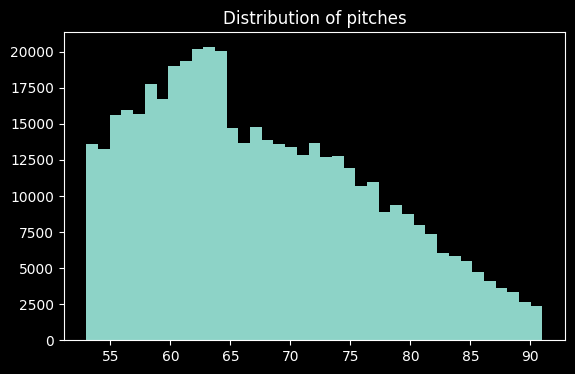

In [7]:
#Creating a list of numerical pitch, duration data, looking at distribution + outliers
import matplotlib.pyplot as plt

letter_notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

def pitch_to_key(num):
    letter = letter_notes[num % 12]
    octave = (num // 12) - 1
    return f"{letter}/{octave}"


def key_to_pitch(key):
    note, octave = key.split("/")
    num_mod_12 = letter_notes.index(note)
    num_floordiv_12 = int(octave) + 1
    num = (12 * num_floordiv_12) + num_mod_12
    return num

f3 = key_to_pitch('F/3')
g6 = key_to_pitch('G/6')

def key_to_pitch_within_bounds(key):
    num = key_to_pitch(key)
    while num < f3:
        num += 12
    while num > g6:
        num -= 12
        
    return num


numerical_data = [[[key_to_pitch_within_bounds(x['key']), x['duration']] for x in i] for i in new_notes]
print(f"Sample of new data format: {numerical_data[0][:5]}")

flat = []
for x in numerical_data:
    flat += list(np.array([y[0] for y in x]).flatten())

plt.style.use("dark_background")
plt.figure(figsize = [4 * ((1 + np.sqrt(5)) / 2), 4])
plt.title("Distribution of pitches")
plt.hist(flat, bins = len(np.unique(flat)))
plt.show() 

#Good, normal-like distribution some overbeating outliers but not too many concerns or a large skew/kurt

In [8]:
#Scaling and creating X and Y sets to fit them to normal distributions
#If results are more impractical, diving by the max might be better as to not alter the distribution shape

all_pitch = flat
all_duration = []
for x in numerical_data:
    all_duration += list(np.array([y[1] for y in x]).flatten())

pitch_max, pitch_min = np.max(all_pitch), np.min(all_pitch)
duration_max, duration_min = np.max(all_duration), np.min(all_duration)

pitch, duration = [], []
for entry in numerical_data:
    pitch_array, duration_array = [], []
    for note in entry:
        pitch_array.append((note[0] - pitch_min) / (pitch_max - pitch_min))
        duration_array.append((note[1] - duration_min) / (pitch_max - pitch_min))
    pitch.append(pitch_array); duration.append(duration_array)

pitch[0][:5], duration[0][:5], 

([0.18421052631578946,
  0.05263157894736842,
  0.2894736842105263,
  0.3684210526315789,
  0.5],
 [0.18421052631578946, 0.0, 0.0, 0.0, 0.0])

In [9]:
pitch_max, pitch_min, duration_max, duration_min = (91, 53, 96, 0)

In [10]:
#Starting with splits of length 16, but likly will try larger ones
xp, xd, yp, yd = [], [], [], []
sequence_length = 32
target_length = sequence_length + 1

minlen = np.min([len(i) for i in pitch])
print(f"Minimum: {minlen}")

for pitch_entry, duration_entry in zip(pitch, duration):
    pitches, durations = [], [] #Samples to convert into x and y

    #Taking before beginning beginning, end, and some in the middle
    for n_before in range(5, 15):
        pitches.append([0 for _ in range(target_length - n_before)] + pitch_entry[:n_before])
        durations.append([0 for _ in range(target_length - n_before)] + duration_entry[:n_before])
        
    
    pitches.append(pitch_entry[:target_length])
    durations.append(duration_entry[:target_length])

    pitches.append(pitch_entry[-(target_length):])
    durations.append(pitch_entry[-(target_length):])

    n_middle = (minlen - (target_length * 2)) // (target_length)
    for i in range(n_middle):
        idx = (i + 1) * target_length
        pitches.append(pitch_entry[idx:idx + target_length])
        durations.append(duration_entry[idx:idx + target_length])

    #Splitting into x and y
    for p, d in zip(pitches, durations):
        xp.append(p[:sequence_length]); yp.append(p[sequence_length])
        xd.append(d[:sequence_length]); yd.append(d[sequence_length])

x = np.array([np.array([p, d]).T for p, d in zip(xp, xd)])
y = np.array([np.array([p, d]).T for p, d in zip(yp, yd)])
x.shape, y.shape

Minimum: 110


((2600, 32, 2), (2600, 2))

In [11]:
#Datasets n Dataloaders
import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

device = 'cuda'
if not torch.cuda.is_available():
    device = 'cpu'

class Ds(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x).to(device).to(torch.float32)
        self.y = torch.tensor(y).to(device).to(torch.float32)
        self.length = len(x)
    def __len__(self):
        return self.length
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.1)

train_ds = Ds(xtrain, ytrain)
test_ds = Ds(xtest, ytest)
train_dl = DataLoader(train_ds, batch_size = 128, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = 128, shuffle = True)
print(len(train_dl), len(test_dl))

19 3


In [12]:
#Starting off with an LSTM-based model since the regression task theoretically should be simpler and to prevent having to use encodings
#Also seeing how attention does and choosing the better method, though dimensionality is small so attention is likely not needed

class Regressor(nn.Module):
    def __init__(self, seqlen, hidden_dim, n_layers, drop, bidir, pooling_kernel_size):
        super().__init__()
        self.ff_projection = nn.Linear(2, hidden_dim)
        self.lstm_stack = nn.LSTM(hidden_dim, hidden_dim, n_layers, True, True, drop, bidir)
        #self.attn_stack = nn.MultiheadAttention(hidden_dim, n_layers, drop)
        self.pooling = nn.MaxPool2d(pooling_kernel_size)
        self.ff1 = nn.Linear(int(seqlen * hidden_dim / ((pooling_kernel_size)**2)), 512)
        if bidir:
            self.ff1 = nn.Linear(2 * int(seqlen * hidden_dim / ((pooling_kernel_size)**2)), 512)
        self.ff2 = nn.Linear(512, 64)
        self.out = nn.Linear(64, 2)
        self.drop = nn.Dropout(drop)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.ff_projection(x)
        x, _ = self.lstm_stack(x)
        #x, _ = self.attn_stack(x, x, x)
        x = self.pooling(x)
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])
        x = self.ff1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.ff2(x)
        x = self.relu(x)
        x = self.out(x)
        return x

model = Regressor(
    seqlen = sequence_length,
    hidden_dim = 256,
    n_layers = 4,
    drop = 0.1,
    bidir = True,
    pooling_kernel_size = 2
).to(device)

s = time.time()
for x, y in train_dl:
    print(x.shape, model(x).shape, y.shape, time.time() - s)
    break

torch.Size([128, 32, 2]) torch.Size([128, 2]) torch.Size([128, 2]) 1.1166367530822754


Epoch 1 starting...
Average Epoch Loss: 0.040323849375310694
Average variance of predictions: 0.019410323945186592
Time took: 41.13721299171448

Epoch 2 starting...
Average Epoch Loss: 0.02988586966928683
Average variance of predictions: 0.0227809600335987
Time took: 39.250194787979126

Epoch 3 starting...
Average Epoch Loss: 0.02677447084141405
Average variance of predictions: 0.025406935595368083
Time took: 39.409745931625366

Epoch 4 starting...
Average Epoch Loss: 0.02771926769300511
Average variance of predictions: 0.02683443585900884
Time took: 40.080069065093994



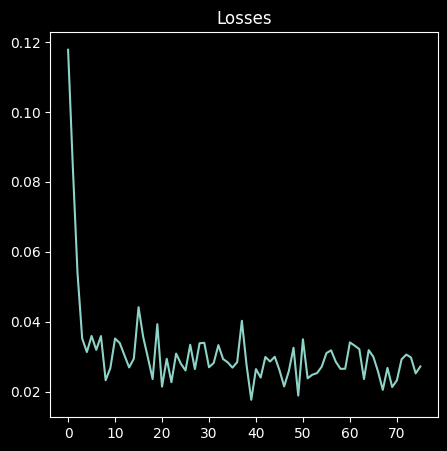

In [13]:
#Training similarly as the last model

epochs = 20
mse = nn.MSELoss()
op = torch.optim.Adam(model.parameters(), lr = 0.0005)
losses = []

#Loop
last_loss = 0
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch} starting...")
    epoch_loss = []
    variance = []

    start = time.time()
    for batch in train_dl:
        x, y = batch
        pred = model(x)
        variance.append(torch.var(pred).item())
        loss = mse(pred, y)
        
        loss += 0.001 * torch.abs(1 - torch.var(pred[:, 1])) #Penalty for low variance on duration
        epoch_loss.append(loss.item())
        losses.append(loss.item())
        
        loss.backward()
        op.step()
        op.zero_grad()
        
    end = time.time()
    print(f"Average Epoch Loss: {np.average(epoch_loss)}")
    print(f"Average variance of predictions: {np.average(variance)}")
    print(f"Time took: {np.average(end - start)}\n")

    if np.abs(last_loss - np.average(epoch_loss)) < 0.001:
        break
    else:
        last_loss = np.average(epoch_loss)
        
        

#Plotting train data
plt.style.use("dark_background")
plt.figure(figsize = [5, 5])
plt.plot(losses)
plt.title("Losses")
plt.show()

Testing:...
Average Testing Loss: 0.02605838080247243, Variance: 1.9466237637242068e-05


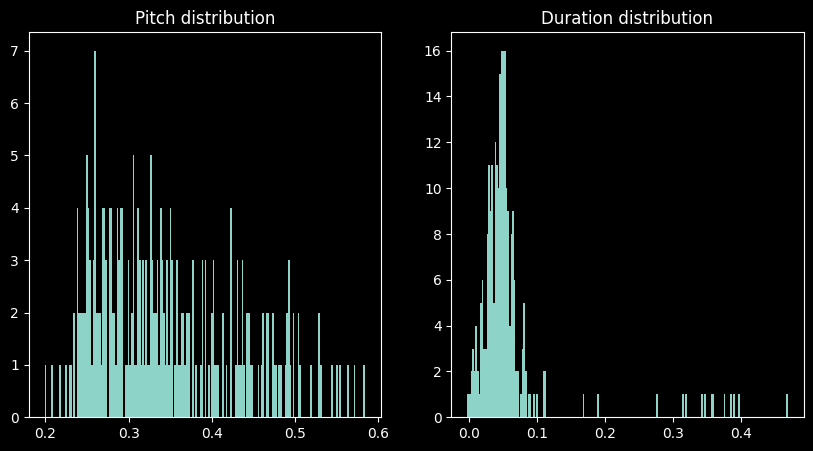

In [14]:
#Calculating test metrics and distributions
print(f"Testing:...")
loss = []
pitch_preds, duration_preds = [], []
for batch in test_dl:
    x, y = batch
    pred = model(x)
    pitch_preds.append(pred[:, 0].cpu().detach().numpy().flatten())
    duration_preds.append(pred[:, 1].cpu().detach().numpy().flatten())
    loss.append(mse(pred, y).item())

print(f'Average Testing Loss: {np.average(loss)}, Variance: {np.var(loss)}')

del pitch_preds[-1]; del duration_preds[-1]
plt.figure(figsize = [10, 5])
plt.subplot(1, 2, 1)
plt.hist(np.array(pitch_preds).flatten(), bins = 200)
plt.title("Pitch distribution")
plt.subplot(1, 2, 2)
plt.hist(np.array(duration_preds).flatten(), bins = 200)
plt.title("Duration distribution")
plt.show()

In [15]:
#Making some predictions

def gen_reg(x, length):
    init_len = len(x)
    print(len(x), init_len + length)
    while len(x) < init_len + length:
        pred = model(torch.tensor([x[-sequence_length:]]).to(device)).tolist()[0]
        x = x + [pred]

    #Reverse standardizing
    gend = []
    print(len(x))
    for pred in x[-length:]:
        p, d = pred[0], pred[1]
        if d < 0: d = 0
        next_entry = [
            int((p * (pitch_max - pitch_min)) + pitch_min),
            int((d * (duration_max - duration_min)) + duration_min)
        ]
        
    
        #Octave correction
        next_entry[0] = int(next_entry[0])
        while next_entry[0] < f3:
            next_entry[0] += 12
        while next_entry[0] > g6:
            next_entry[0] -= 12
        
        gend.append(next_entry)
    return gend

gend = 0
start = time.time()
for x, _ in test_dl:
    print(x.tolist()[0])
    gend = gen_reg(x.tolist()[0], 10)
    break

print(f"Time took: {time.time() - start}")
len(gend), gend

[[0.21052631735801697, 0.05263157933950424], [0.07894736528396606, 0.07894736528396606], [0.31578946113586426, 0.07894736528396606], [0.21052631735801697, 0.0], [0.34210526943206787, 0.05263157933950424], [0.18421052396297455, 0.0], [0.07894736528396606, 0.0], [0.21052631735801697, 0.15789473056793213], [0.07894736528396606, 0.05263157933950424], [0.31578946113586426, 0.07894736528396606], [0.21052631735801697, 0.0], [0.34210526943206787, 0.05263157933950424], [0.18421052396297455, 0.0], [0.07894736528396606, 0.05263157933950424], [0.6315789222717285, 0.18421052396297455], [0.21052631735801697, 0.0], [0.07894736528396606, 0.07894736528396606], [0.31578946113586426, 0.07894736528396606], [0.21052631735801697, 0.0], [0.5789473652839661, 0.02631578966975212], [0.34210526943206787, 0.0], [0.18421052396297455, 0.0], [0.7105262875556946, 0.05263157933950424], [0.07894736528396606, 0.0], [0.6315789222717285, 0.02631578966975212], [0.5789473652839661, 0.02631578966975212], [0.21052631735801697

(10,
 [[66, 7],
  [66, 4],
  [66, 7],
  [66, 7],
  [65, 8],
  [65, 7],
  [65, 8],
  [64, 6],
  [65, 9],
  [64, 8]])

In [16]:
#Exporting model
torch.save(model.state_dict(), '/kaggle/working/model.pth')